# The Forward and Backward Passes

The MINST data file `minst.pkl.gz` can be found at https://www.kaggle.com/datasets/pablotab/mnistpklgz

In [39]:
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import tensor
from fastcore.test import test_close
# torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'

torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('/home/yzhao/data')
path_gz = path_data / 'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Plot Images with matplotlib

We can use `matplotlib.pyplot.imshow` to show these handwritten digits as heatmap images.

To plot one figure to see its content:

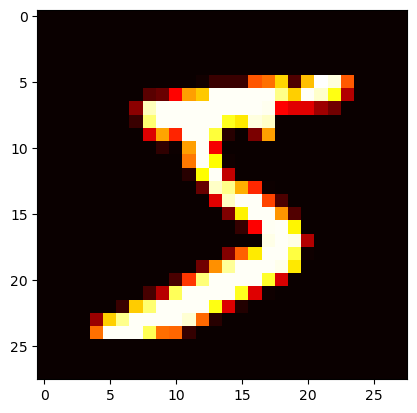

In [102]:
img = x_train[0,:].reshape(28, 28).numpy()
plt.imshow(img, cmap='hot', interpolation='none')

To plot multiple figures:

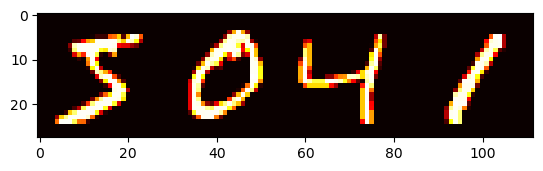

In [103]:
img1 = x_train[0,:].reshape(28, 28).numpy()
img2 = x_train[1,:].reshape(28, 28).numpy()
img3 = x_train[2,:].reshape(28, 28).numpy()
img4 = x_train[3,:].reshape(28, 28).numpy()
plt.imshow(np.hstack([img1, img2, img3, img4]), cmap='hot', interpolation='none')

Or more generically

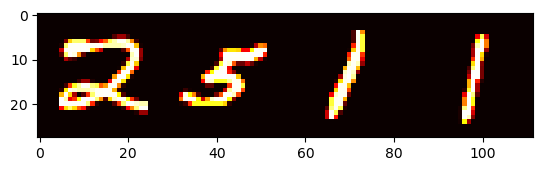

In [107]:
sz = 4
sample_idx = np.random.randint((x_train.size(0)), size=sz)
images = x_train[sample_idx, :].reshape(sz, 28, 28)
images = np.hstack([x.squeeze(0).numpy() for x in torch.split(images, 1)])
plt.imshow(images, cmap='hot', interpolation='none')

## Building a Simple Neural Net

In [111]:
n, m = x_train.shape
c = y_train.max() + 1
n, m, c

(50000, 784, tensor(10))

In [112]:
# num hidden 
nh = 50

In [113]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.rand(nh, 1)
b2 = torch.zeros(1)

In [126]:
def lin(x, w, b): return x @ w + b
def relu(x): return x.clamp_min(0.)

In [127]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [132]:
def model(xb): 
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

model(x_train).shape

torch.Size([50000, 1])

### Loss Function: MSE

In [133]:
res = model(x_valid)
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [139]:
res[:, 0].shape, y_valid.shape

(torch.Size([10000]), torch.Size([10000]))

In [140]:
def mse(output, targ): return (output[:,0] - targ).pow(2).mean()

In [141]:
mse(model(x_train), y_train)

tensor(3769.66)

### Gradient and the Backward pass

In [143]:
from sympy import symbols, diff
x, y = symbols('x y')
diff(x**2, x)

2*x

In [144]:
diff(3*x**2 + 9, x)

6*x

<img src="https://raw.githubusercontent.com/Climbo-Dev/climbo-code-samples/main/images/param_grad_n_chain_rule_explained.png" width="400">

In [145]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [155]:
x = tensor([[1,2,3],[4,5,6]])
x.size(), x.unsqueeze(-1).size(), x.unsqueeze(0).size(), x.unsqueeze(1).size()

(torch.Size([2, 3]),
 torch.Size([2, 3, 1]),
 torch.Size([1, 2, 3]),
 torch.Size([2, 1, 3]))